### What we're going to cover

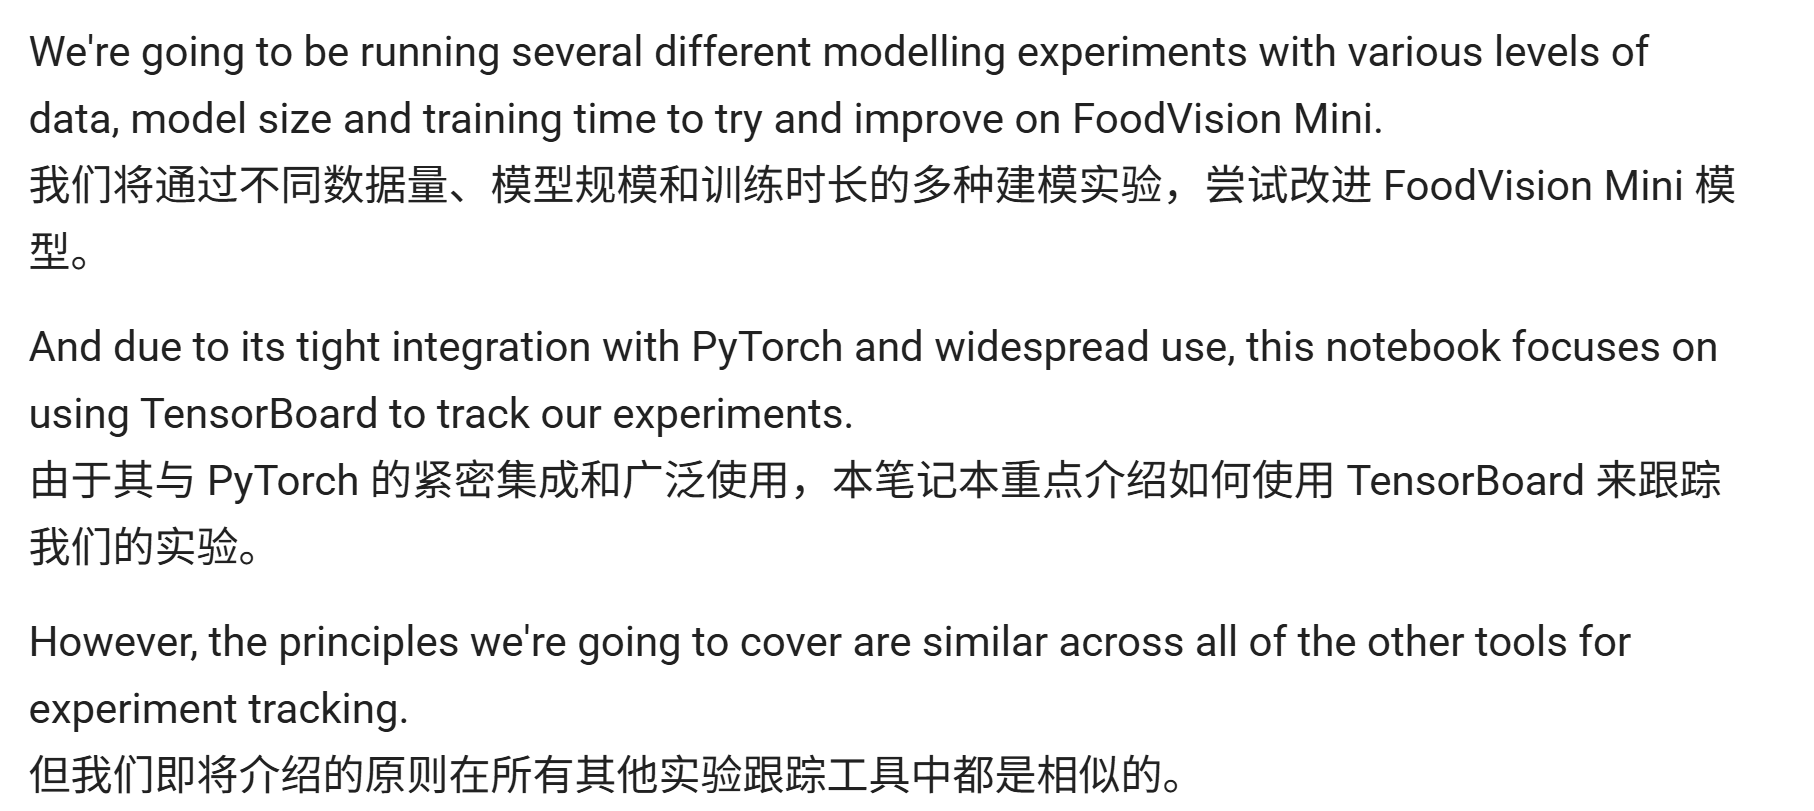

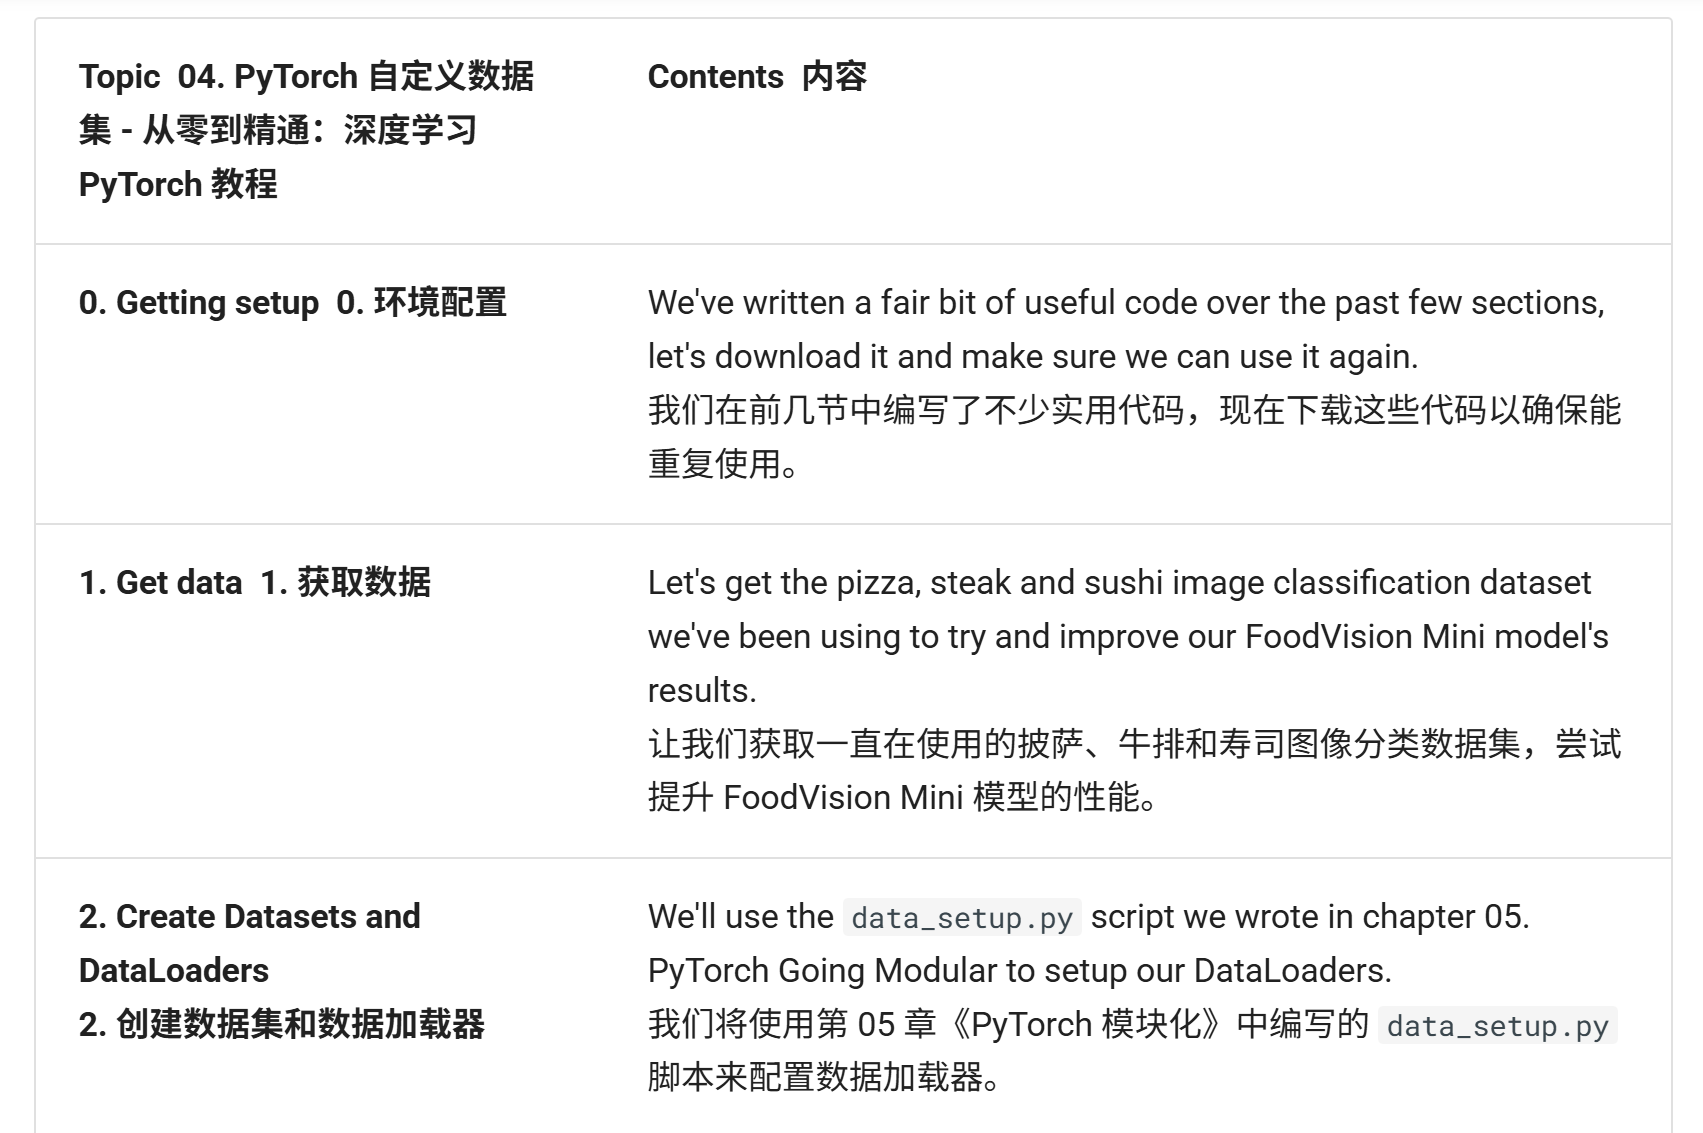

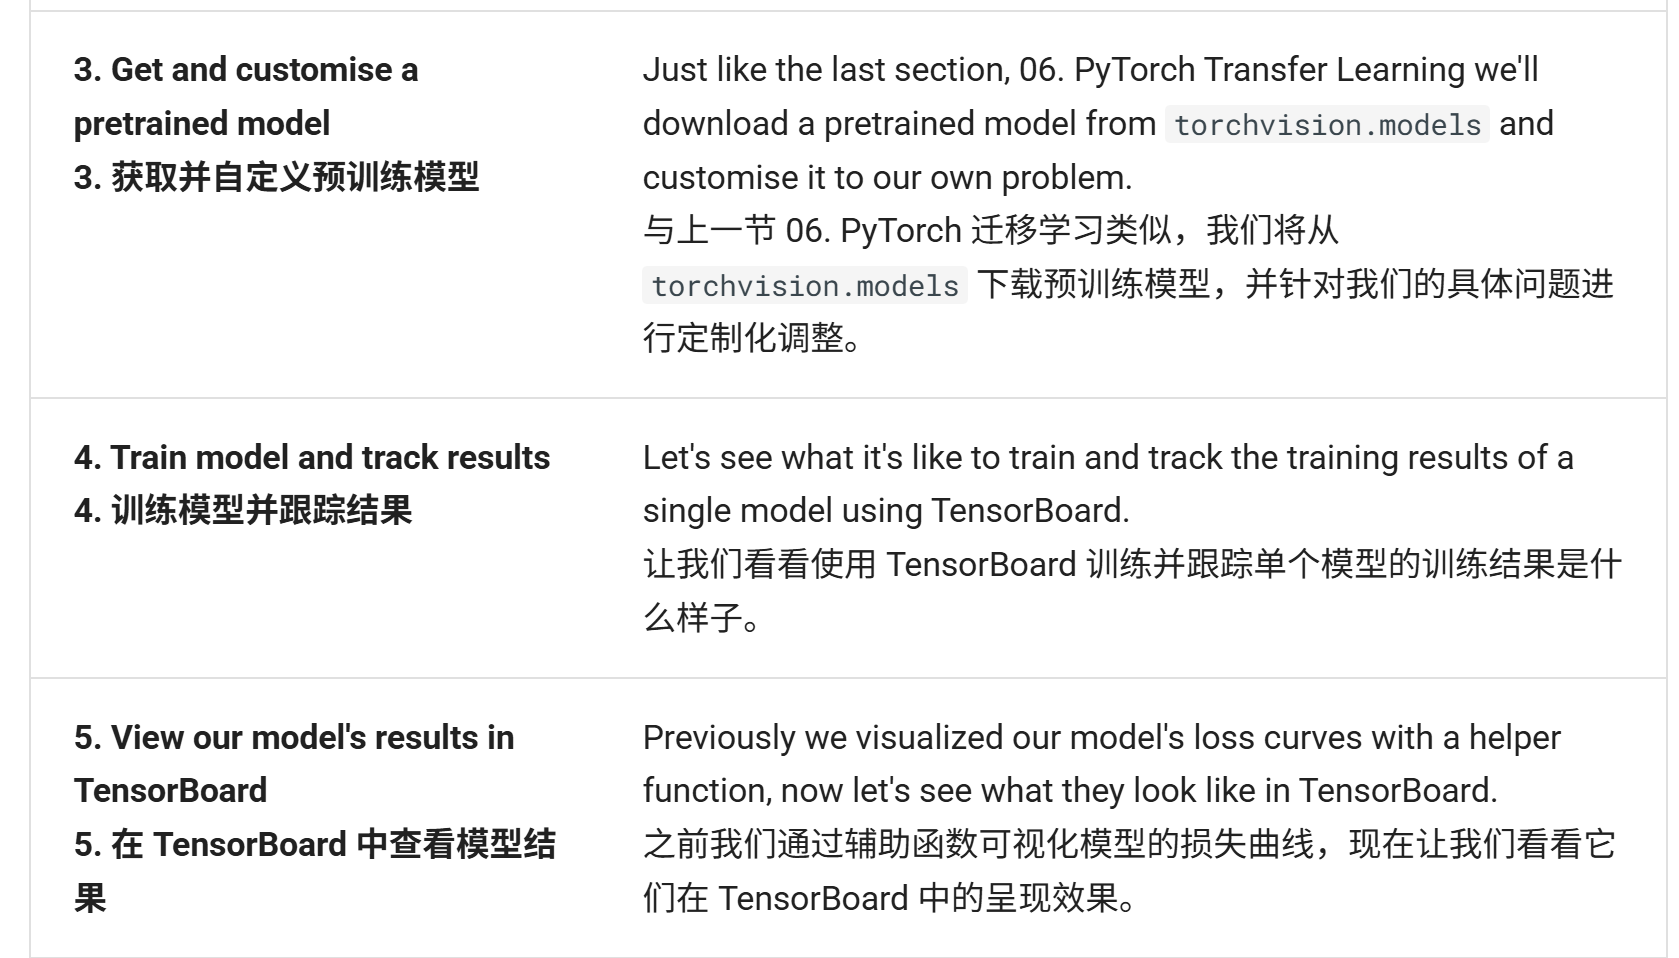

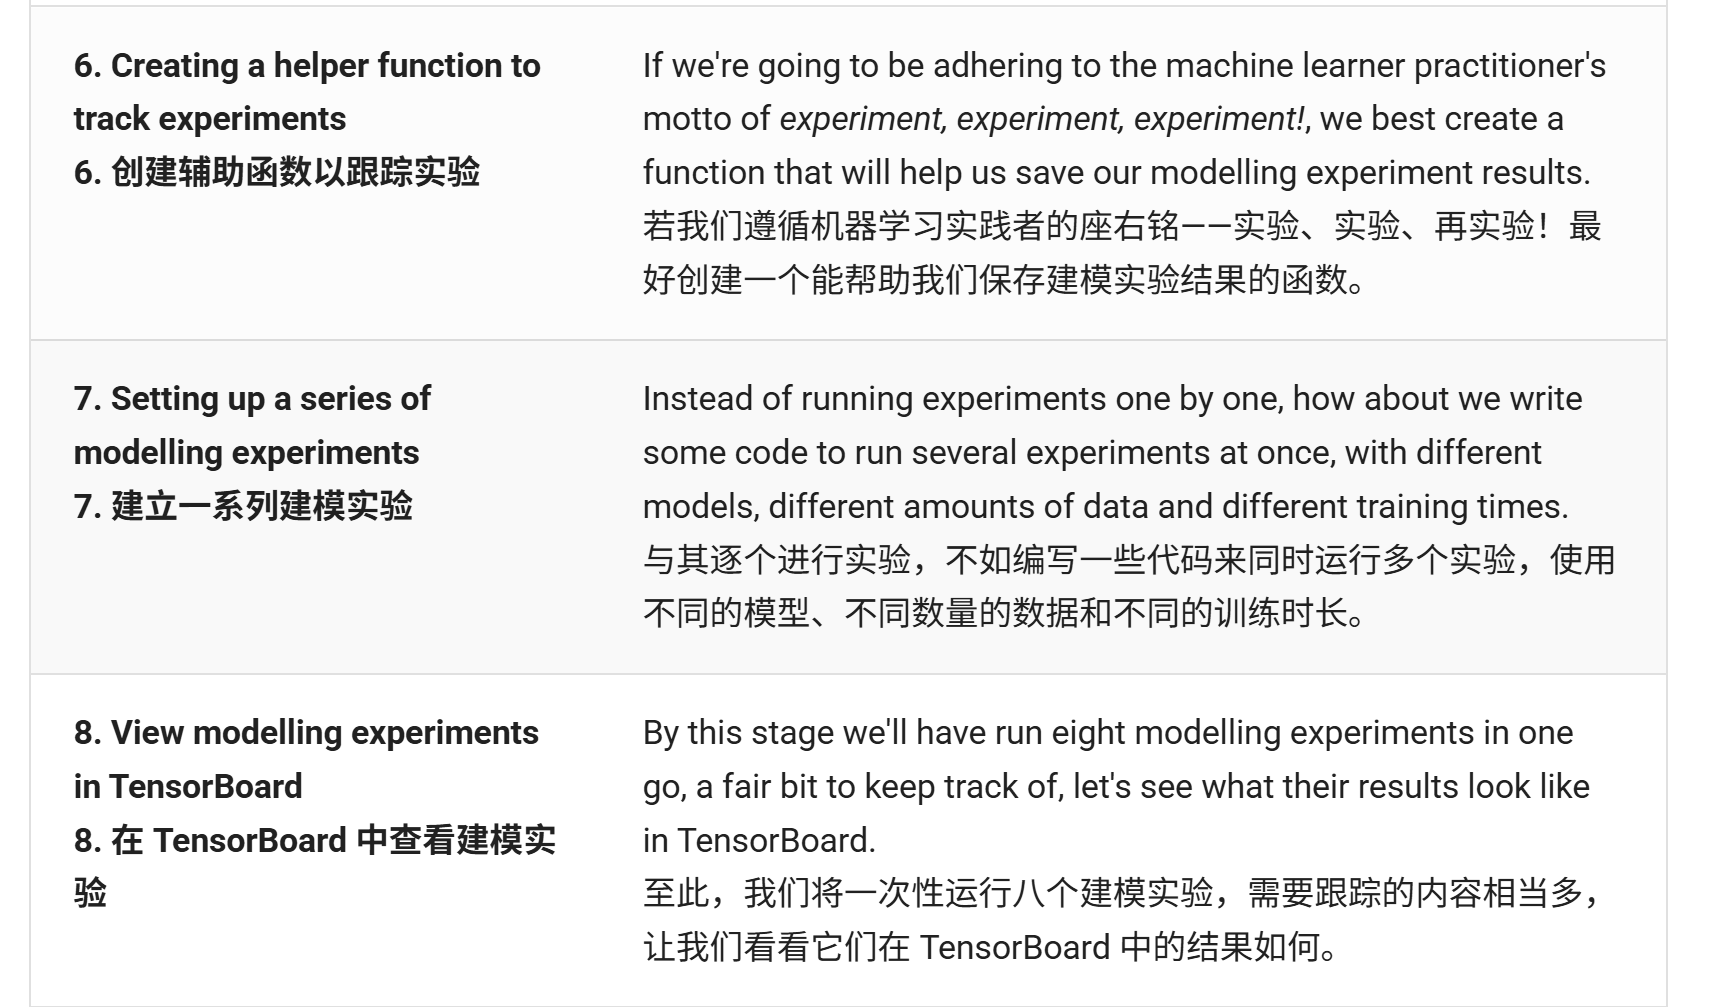

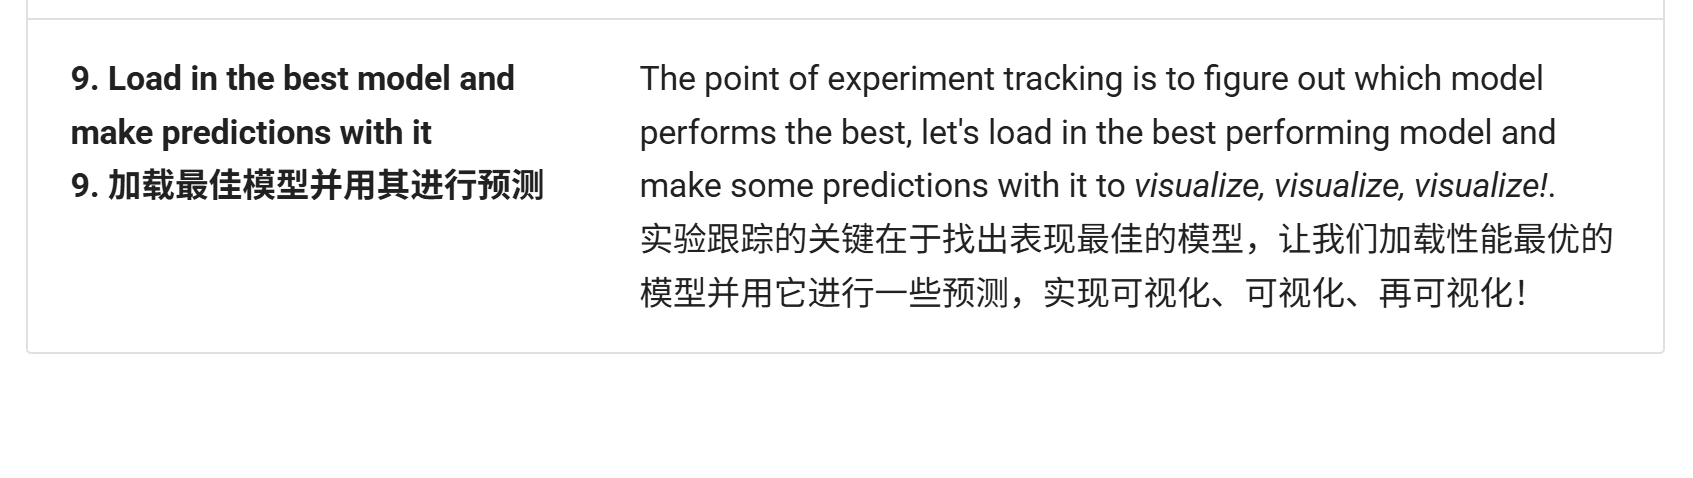

### Getting setup

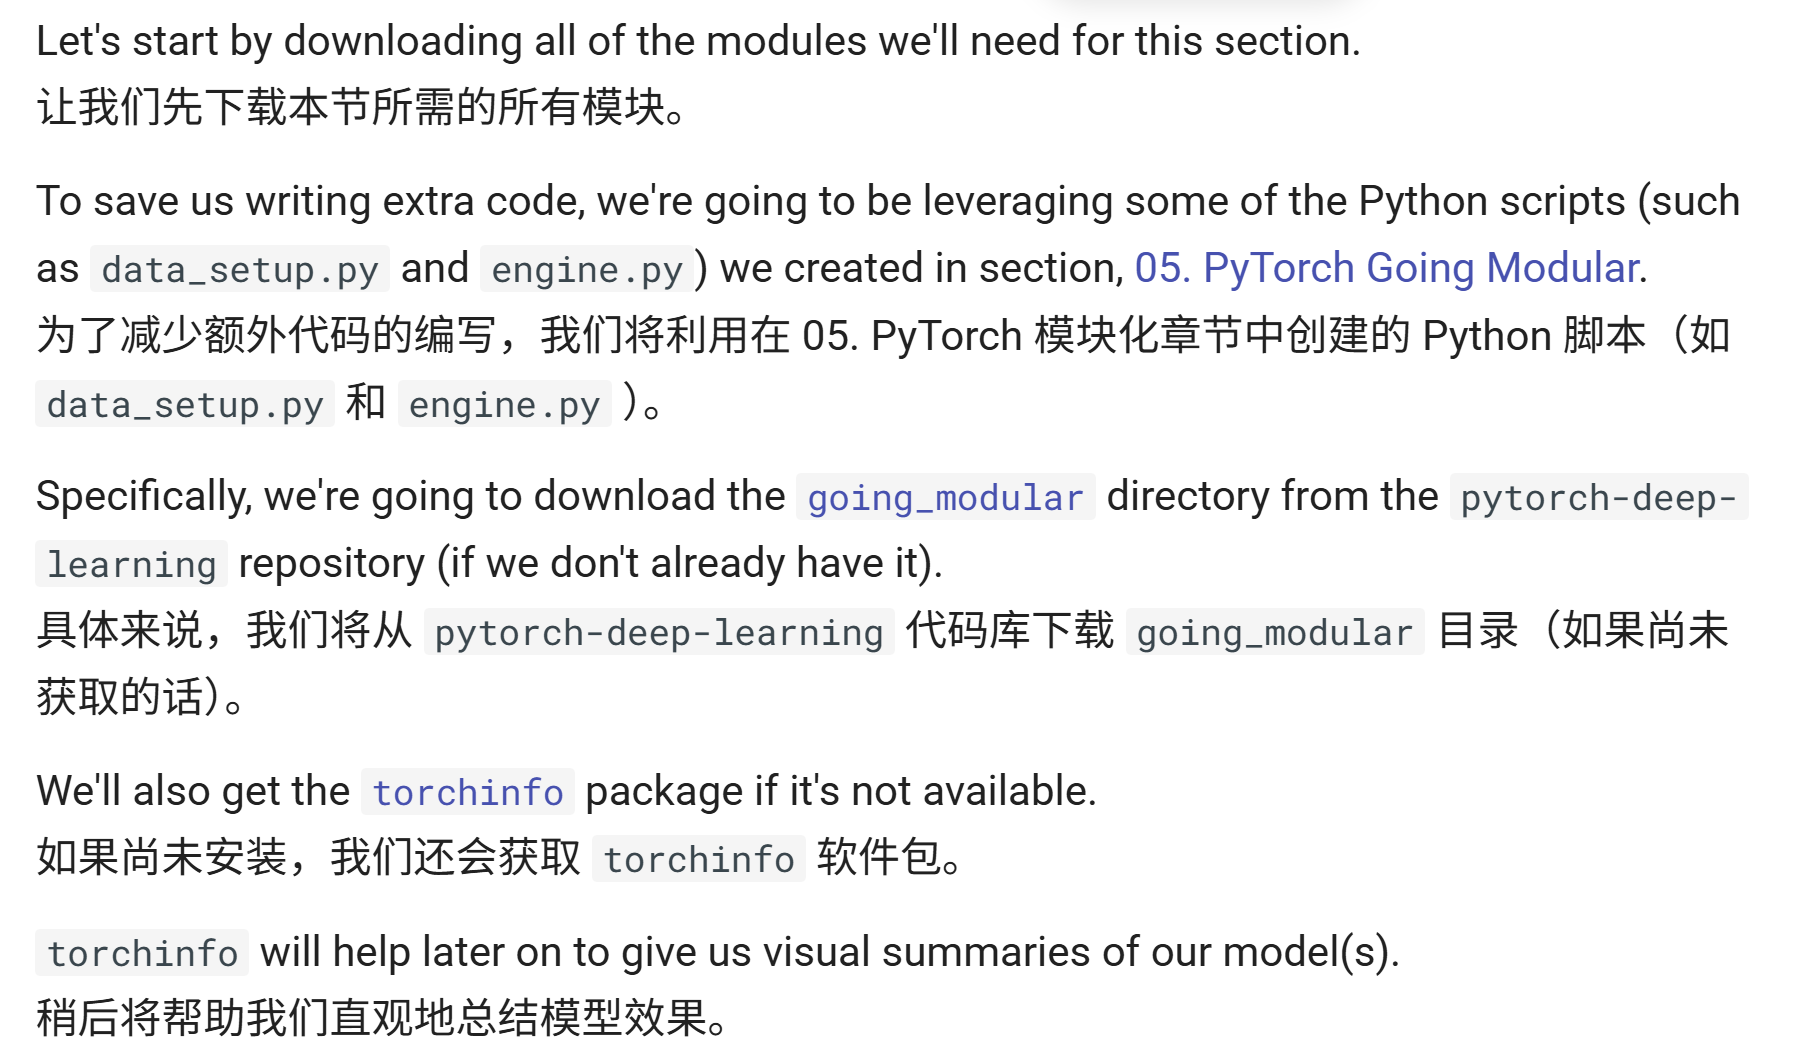

In [3]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.3.1+cu118
torchvision version: 0.18.1+cu118


In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 20.64 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


/home/ssliang/miniconda3/envs/pytorh_ssliang/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

### 1. Get data



In [7]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

### 2. Create Datasets and DataLoaders



In [8]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7f6c07da2ee0>,
 ['pizza', 'steak', 'sushi'])

### 3. Getting a pretrained model, freezing the base layers and changing the classifier head

In [9]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD 

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
# model

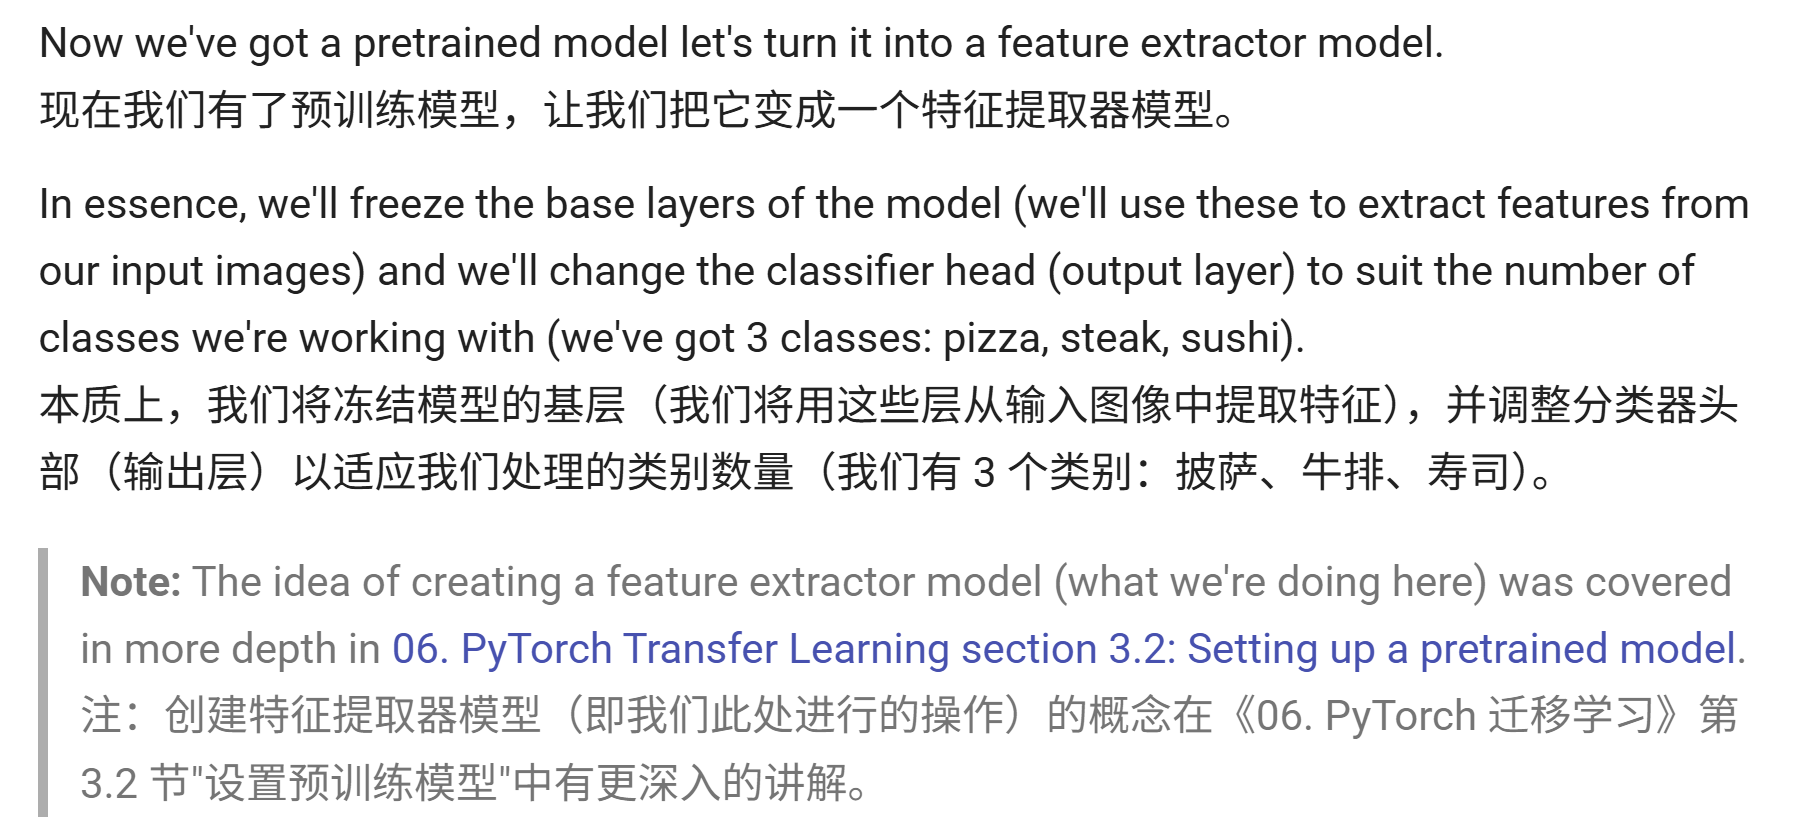

In [10]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False
    
# Since we're creating a new layer with random weights (torch.nn.Linear), 
# let's set the seeds
set_seeds() 

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(device))

In [11]:
from torchinfo import summary

# # Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 4. Train model and track results



In [12]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

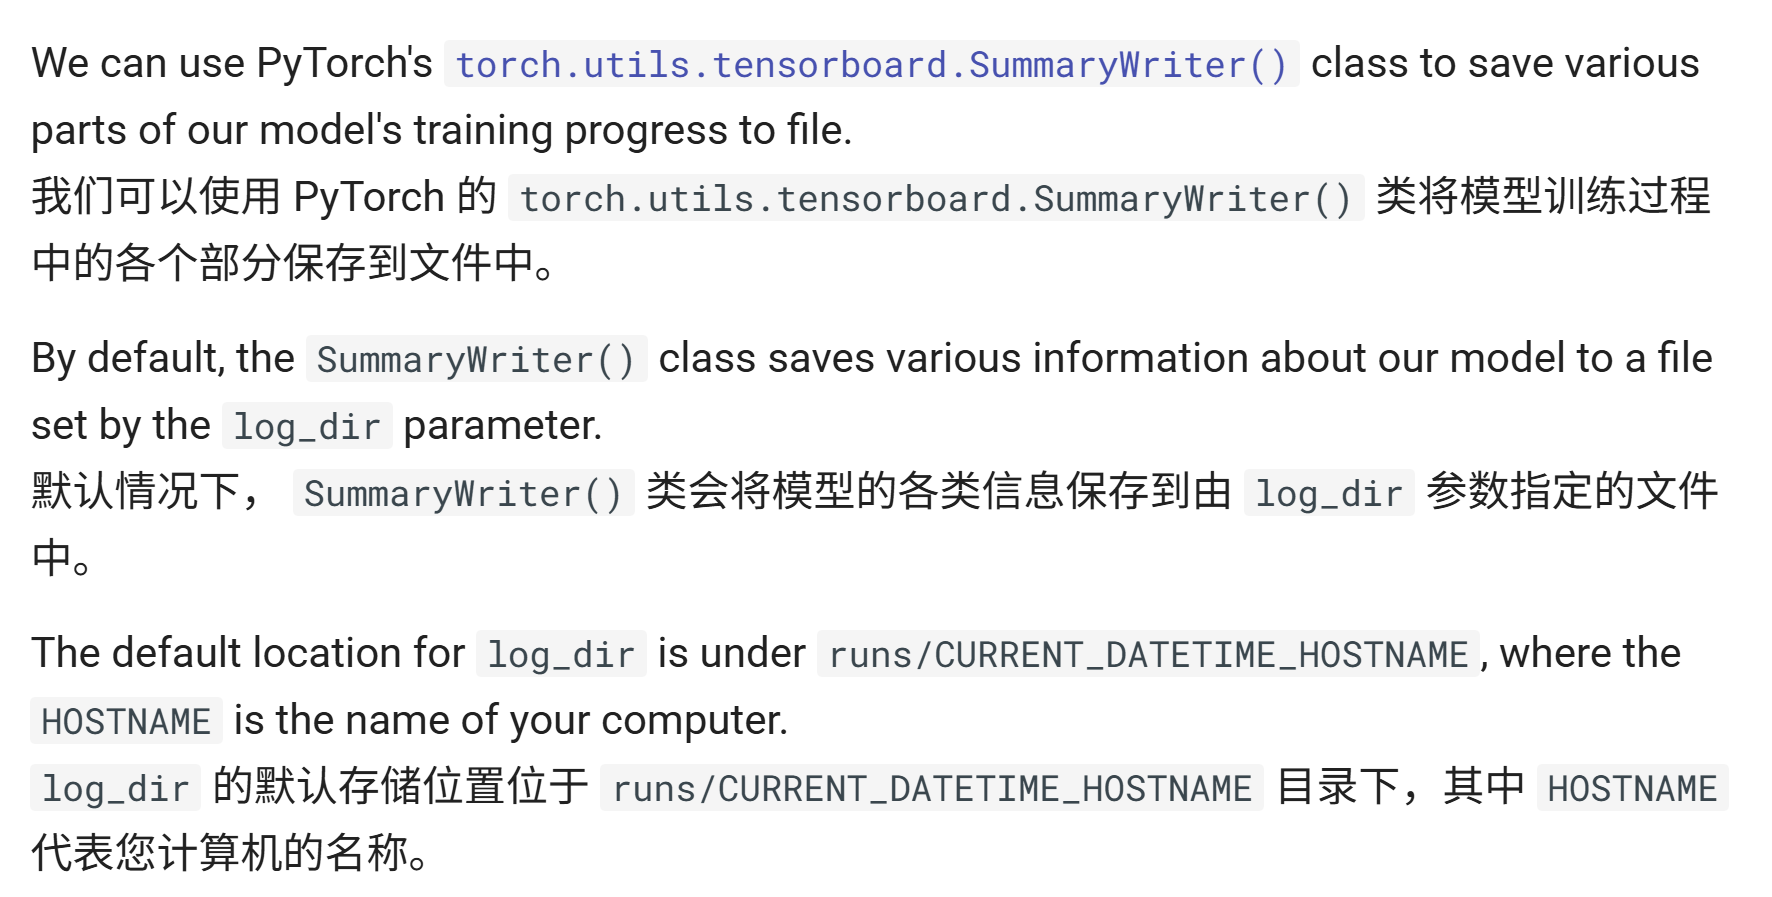

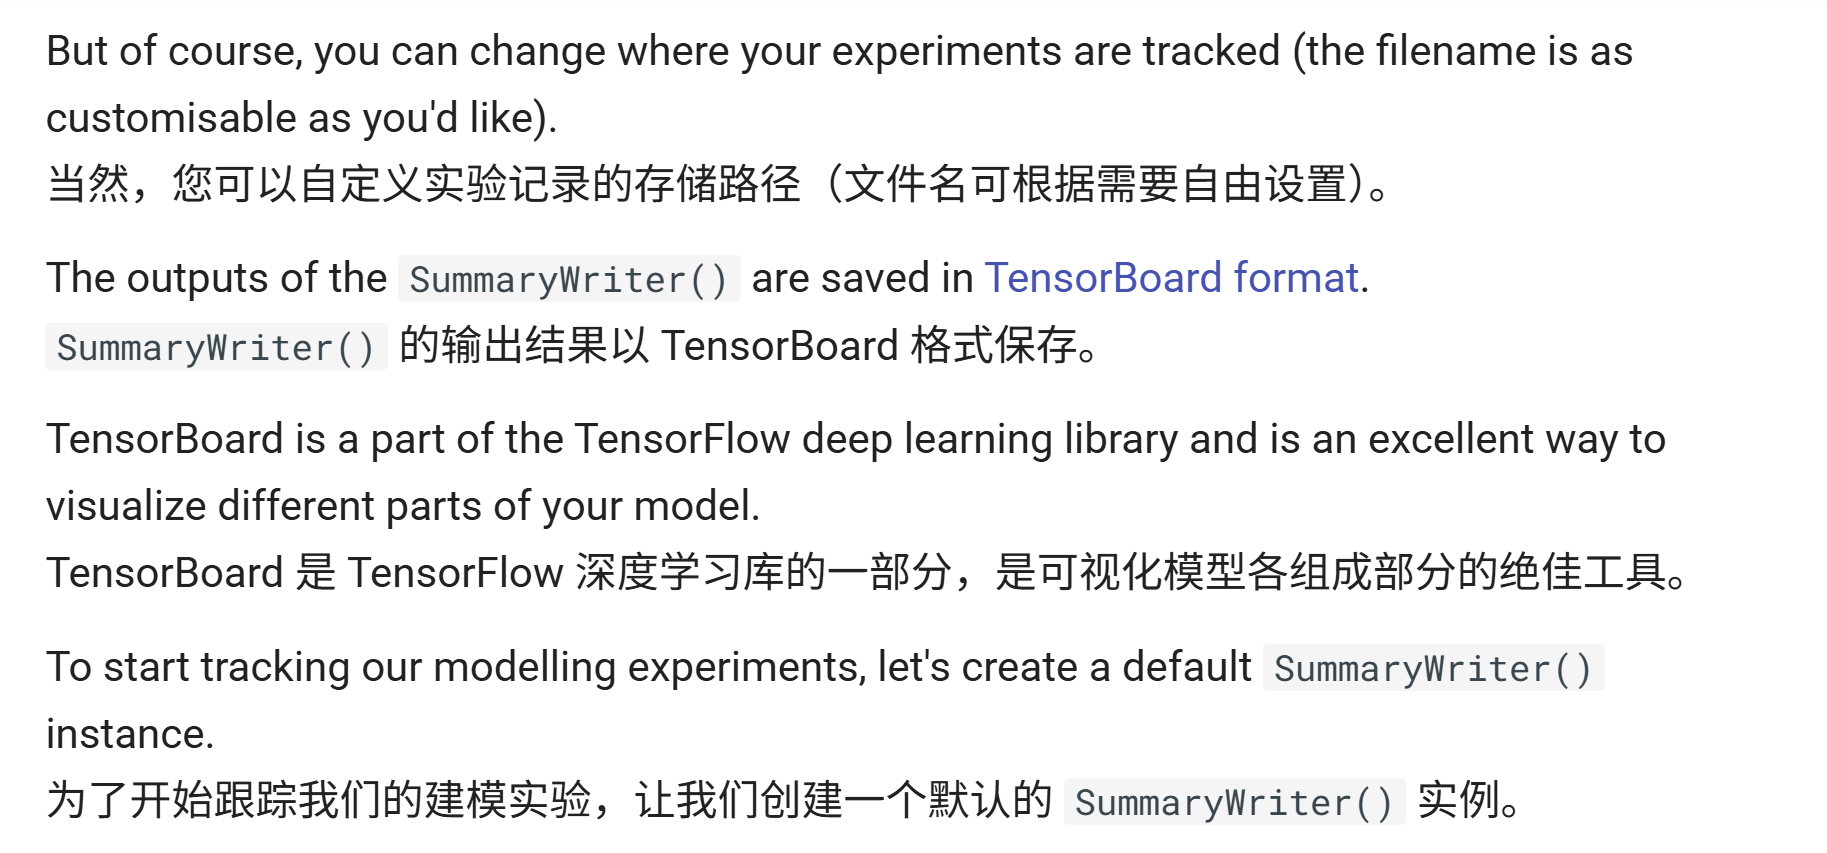

In [13]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    %pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter


# Create a writer with all default settings
writer = SummaryWriter()

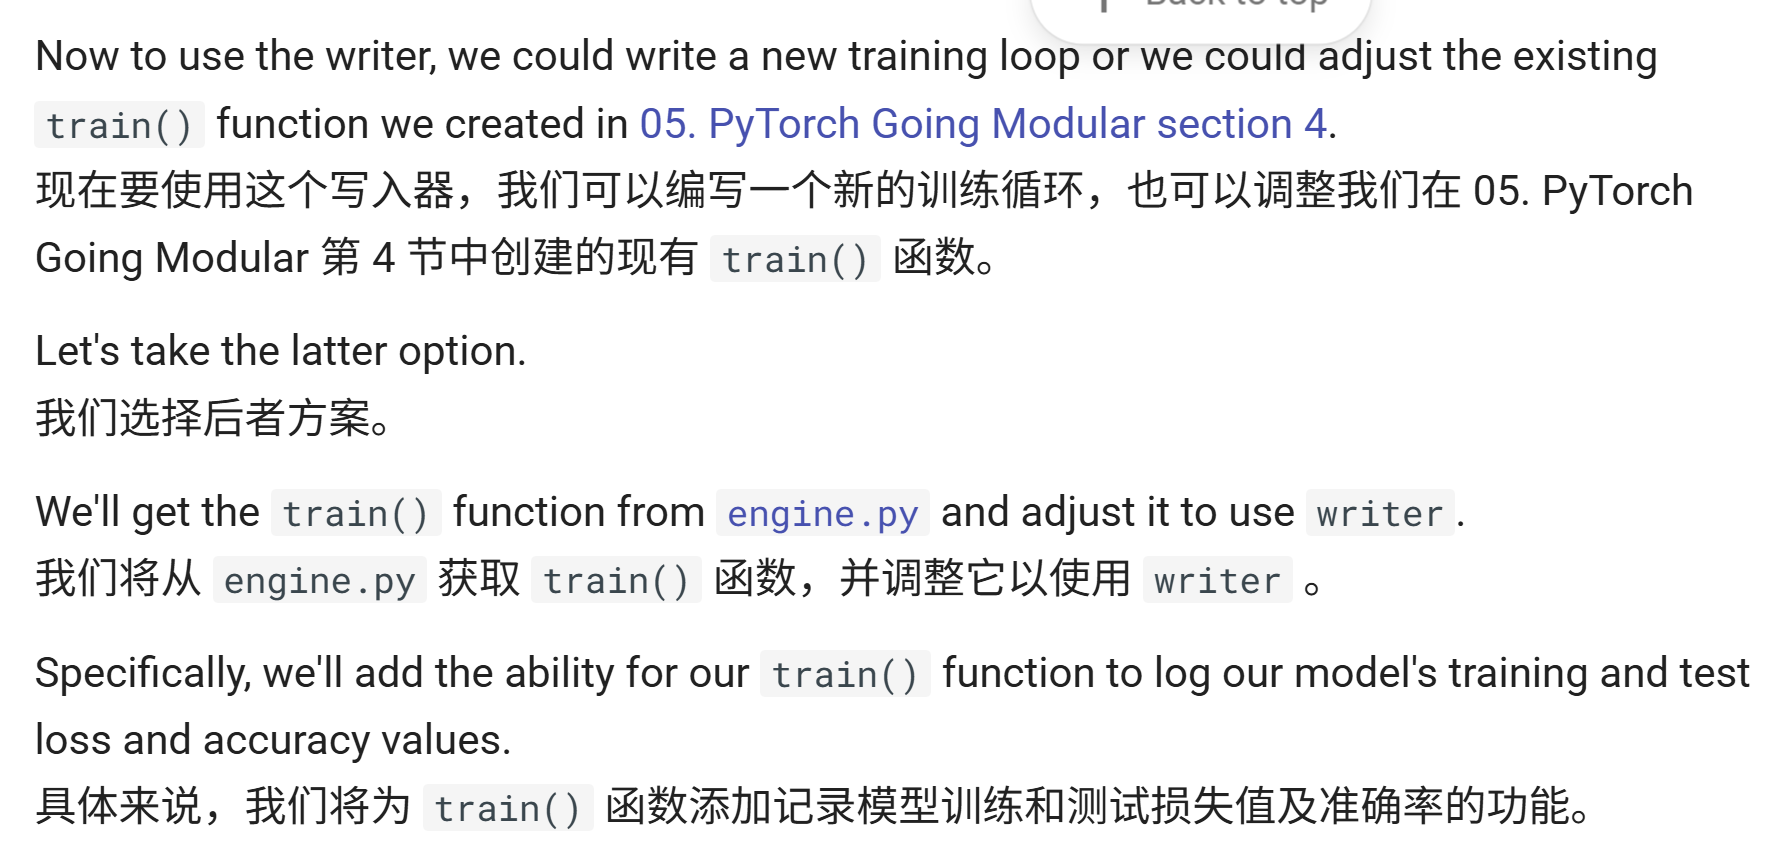

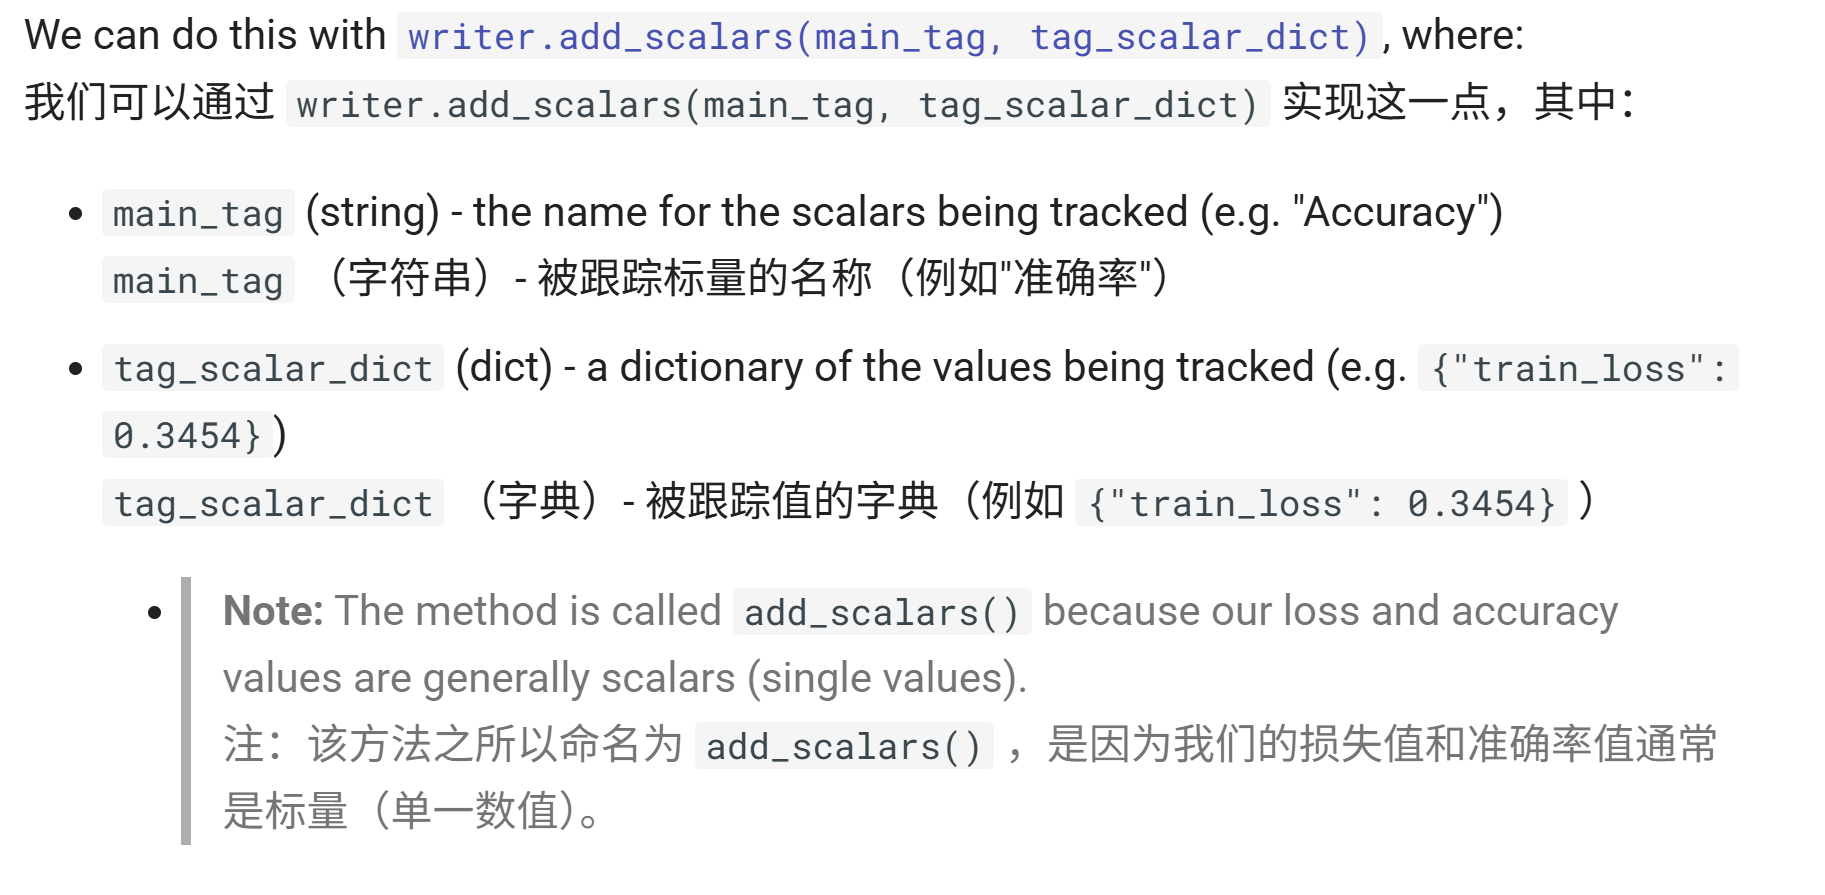

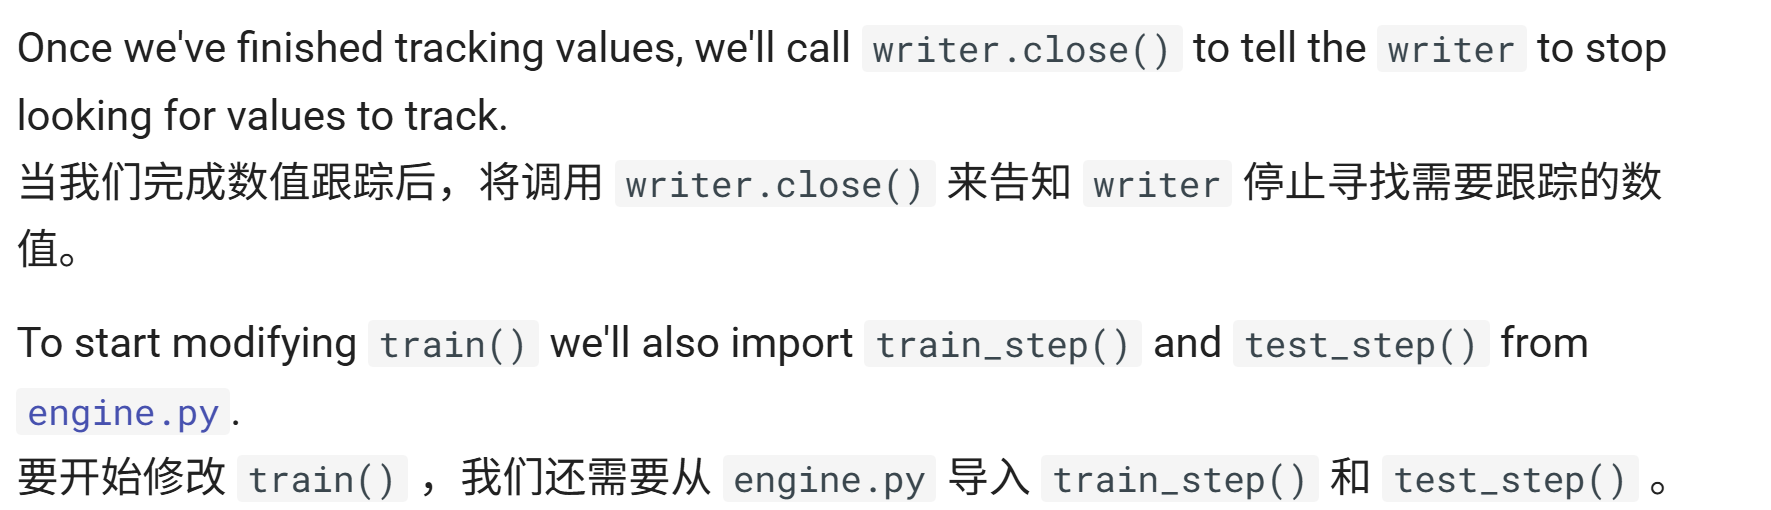

In [15]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

# Import train() function from: 
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
        model: A PyTorch model to be trained and tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be tested on.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        epochs: An integer indicating how many epochs to train for.
        device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

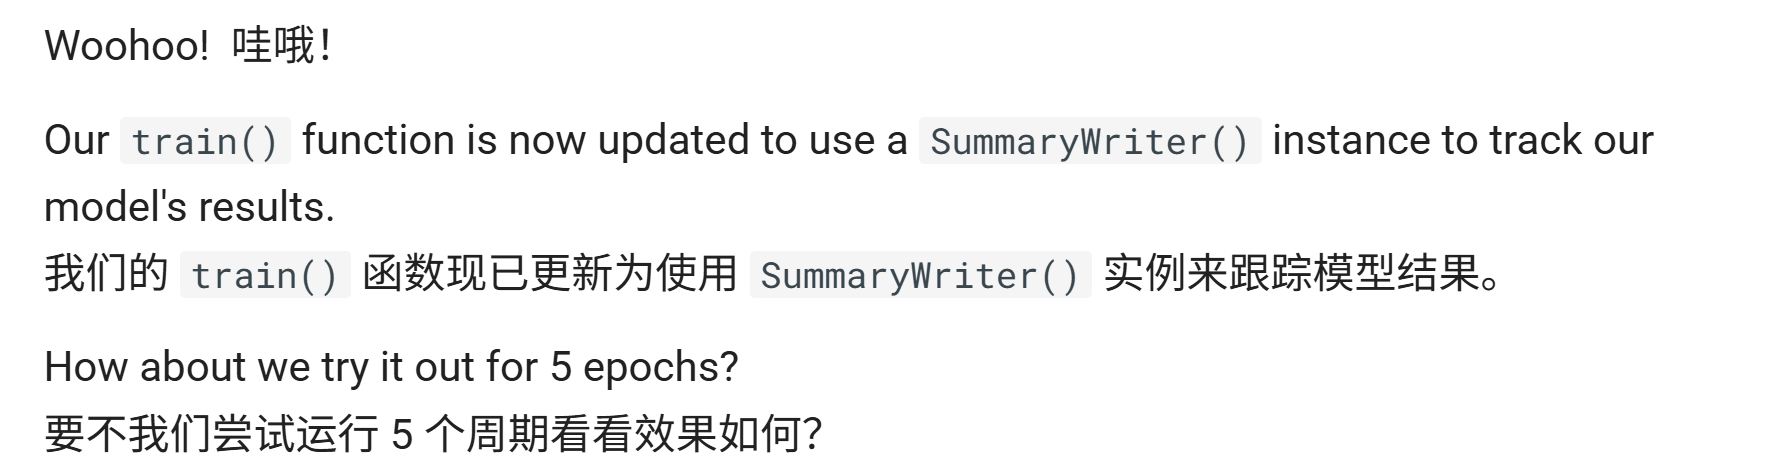

In [16]:
# Train model
# Note: Not using engine.train() since the original script isn't updated to use writer
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9132 | test_acc: 0.5398


 20%|██        | 1/5 [00:09<00:39,  9.85s/it]

Epoch: 2 | train_loss: 0.8975 | train_acc: 0.6562 | test_loss: 0.7837 | test_acc: 0.8561


 40%|████      | 2/5 [00:19<00:28,  9.61s/it]

Epoch: 3 | train_loss: 0.8038 | train_acc: 0.7461 | test_loss: 0.6722 | test_acc: 0.8864


 60%|██████    | 3/5 [00:29<00:19,  9.69s/it]

Epoch: 4 | train_loss: 0.6770 | train_acc: 0.8516 | test_loss: 0.6698 | test_acc: 0.8049


 80%|████████  | 4/5 [00:39<00:09,  9.86s/it]

Epoch: 5 | train_loss: 0.7065 | train_acc: 0.7188 | test_loss: 0.6745 | test_acc: 0.7737


100%|██████████| 5/5 [00:49<00:00,  9.87s/it]


### 5. View our model's results in Tensorboard

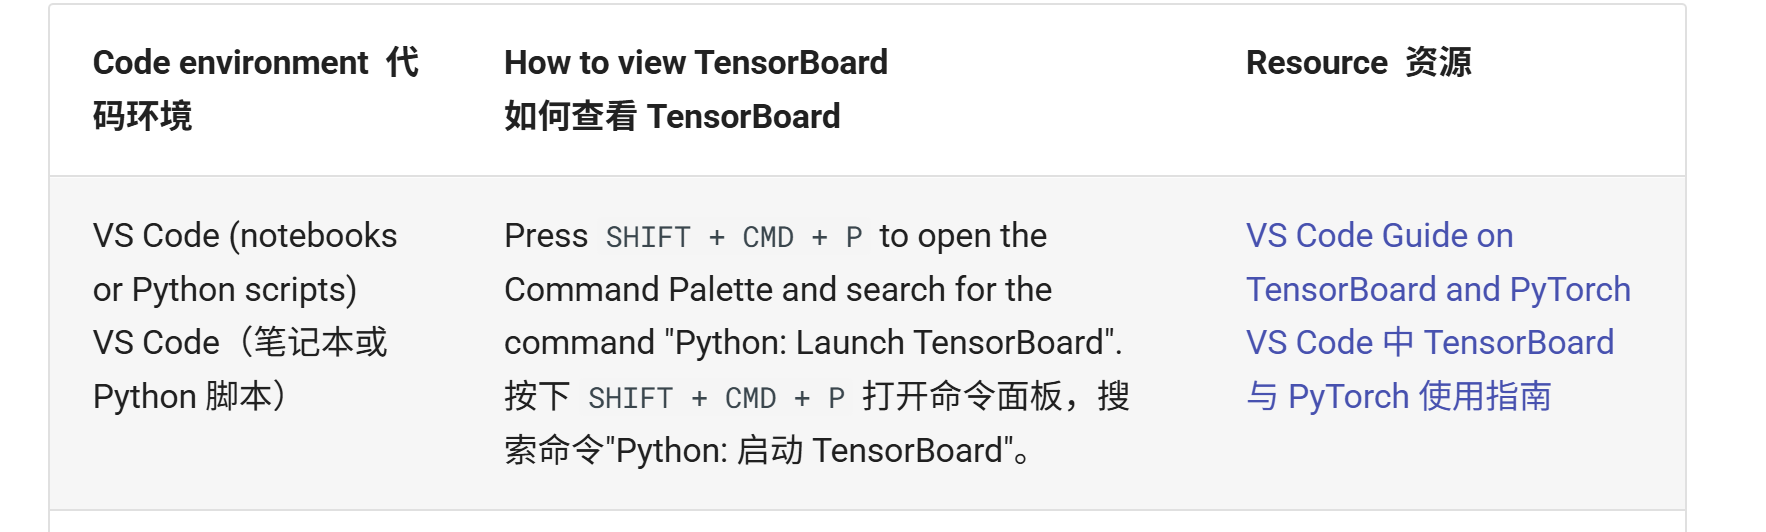

### 6. Create a helper function to build `SummaryWriter()` instances

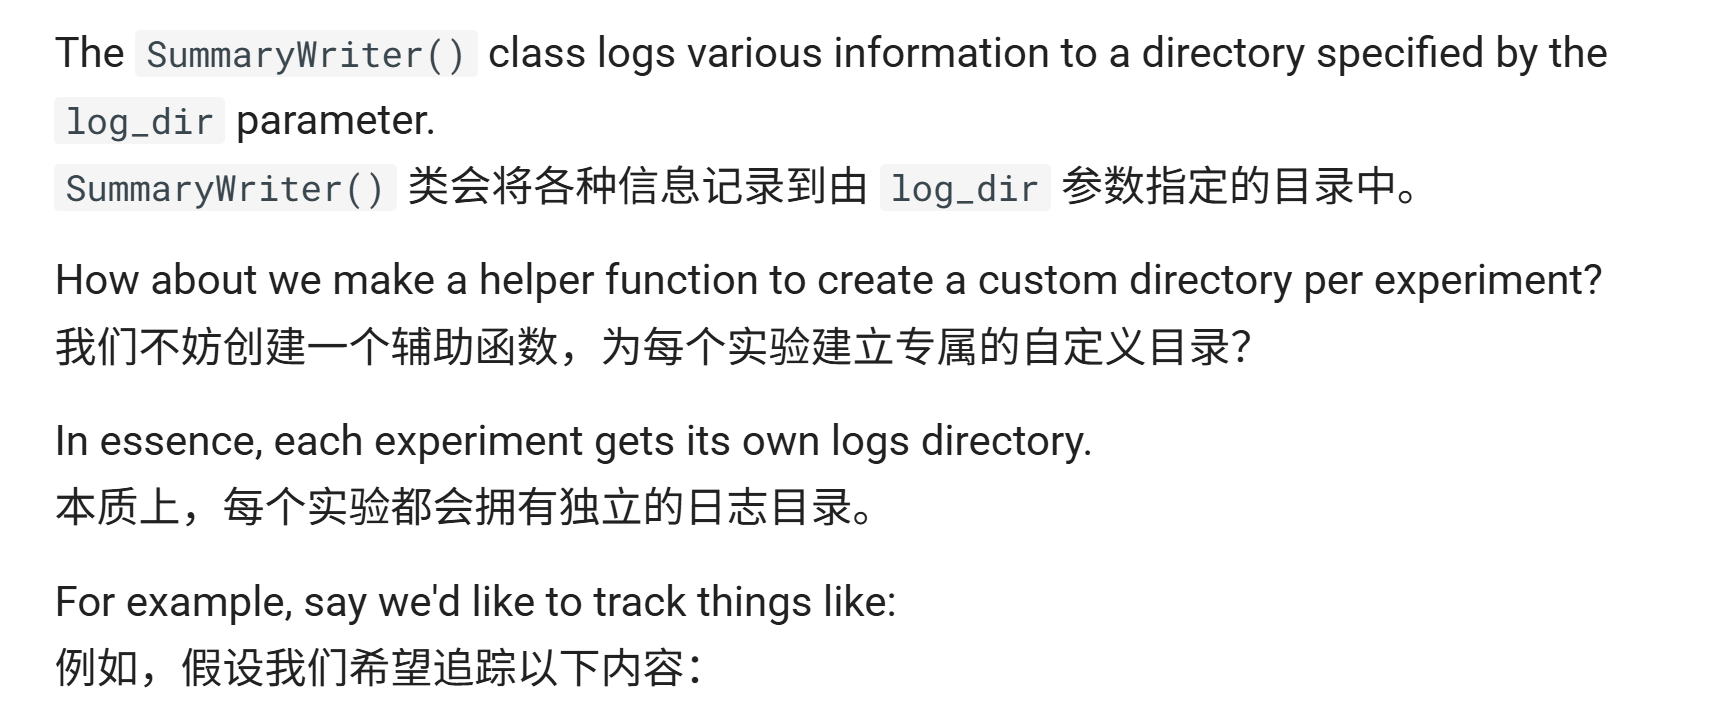

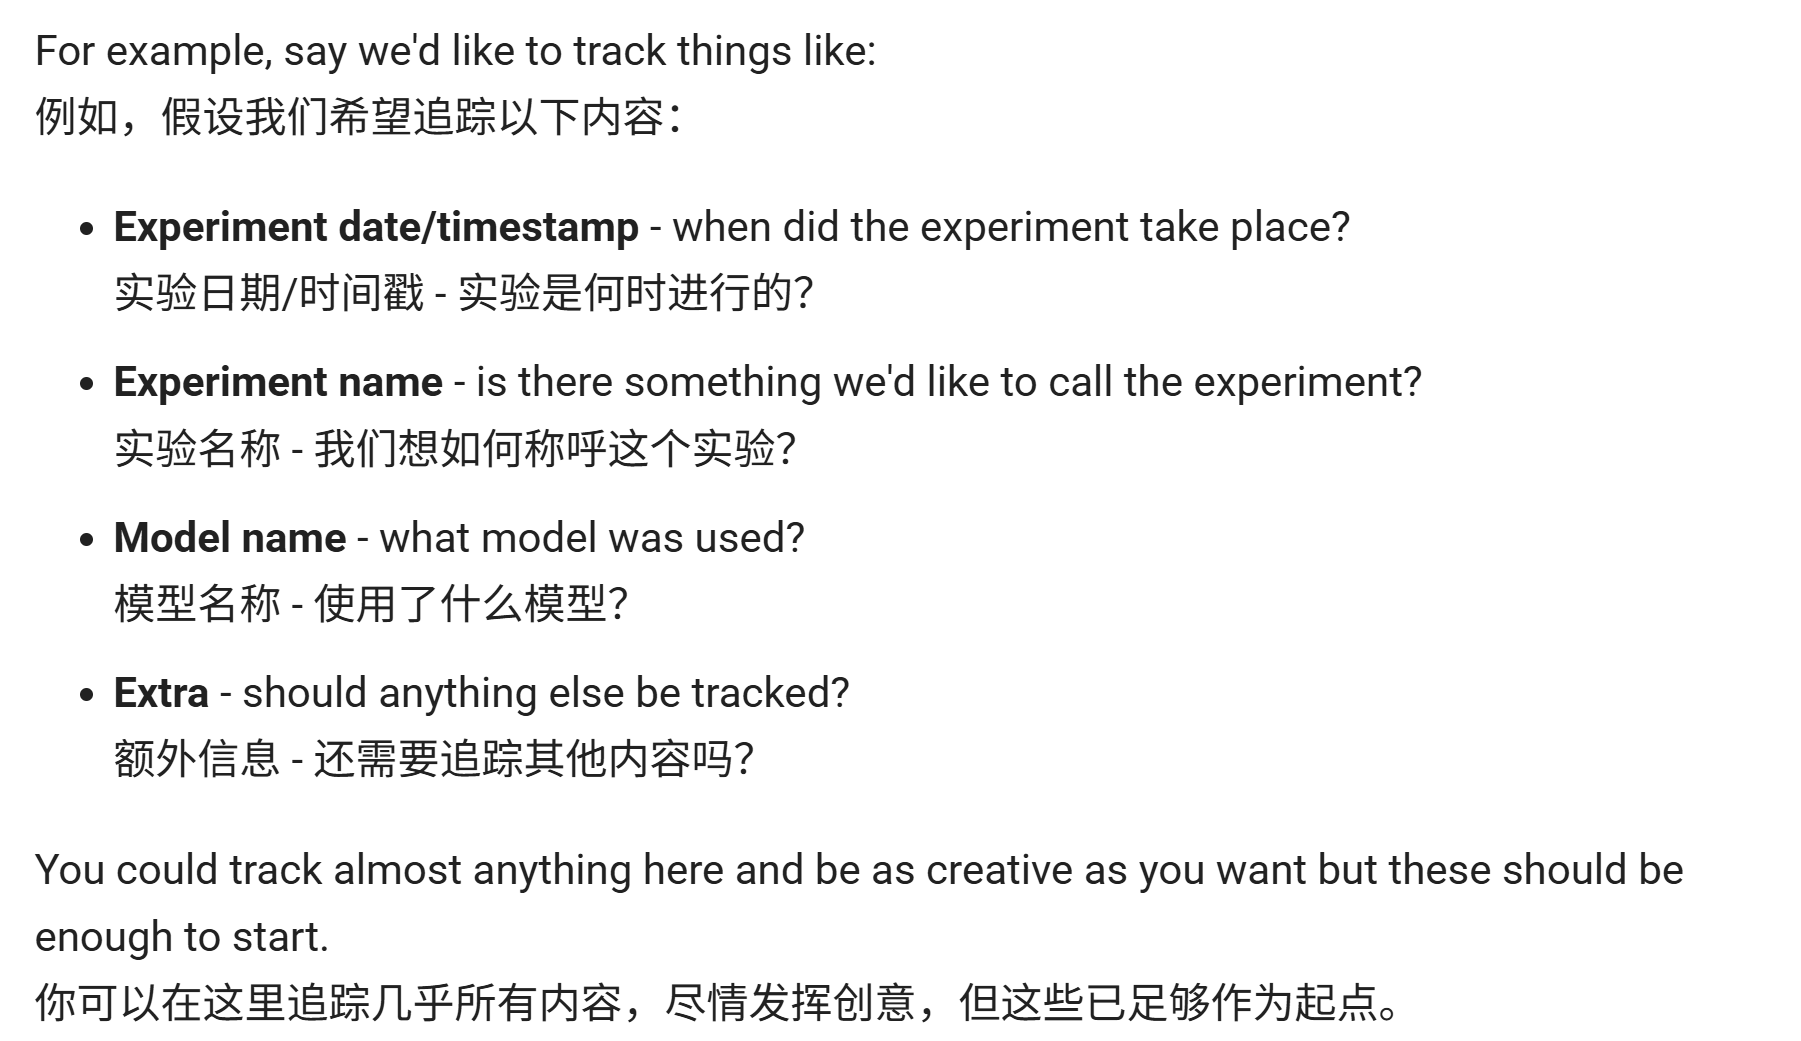

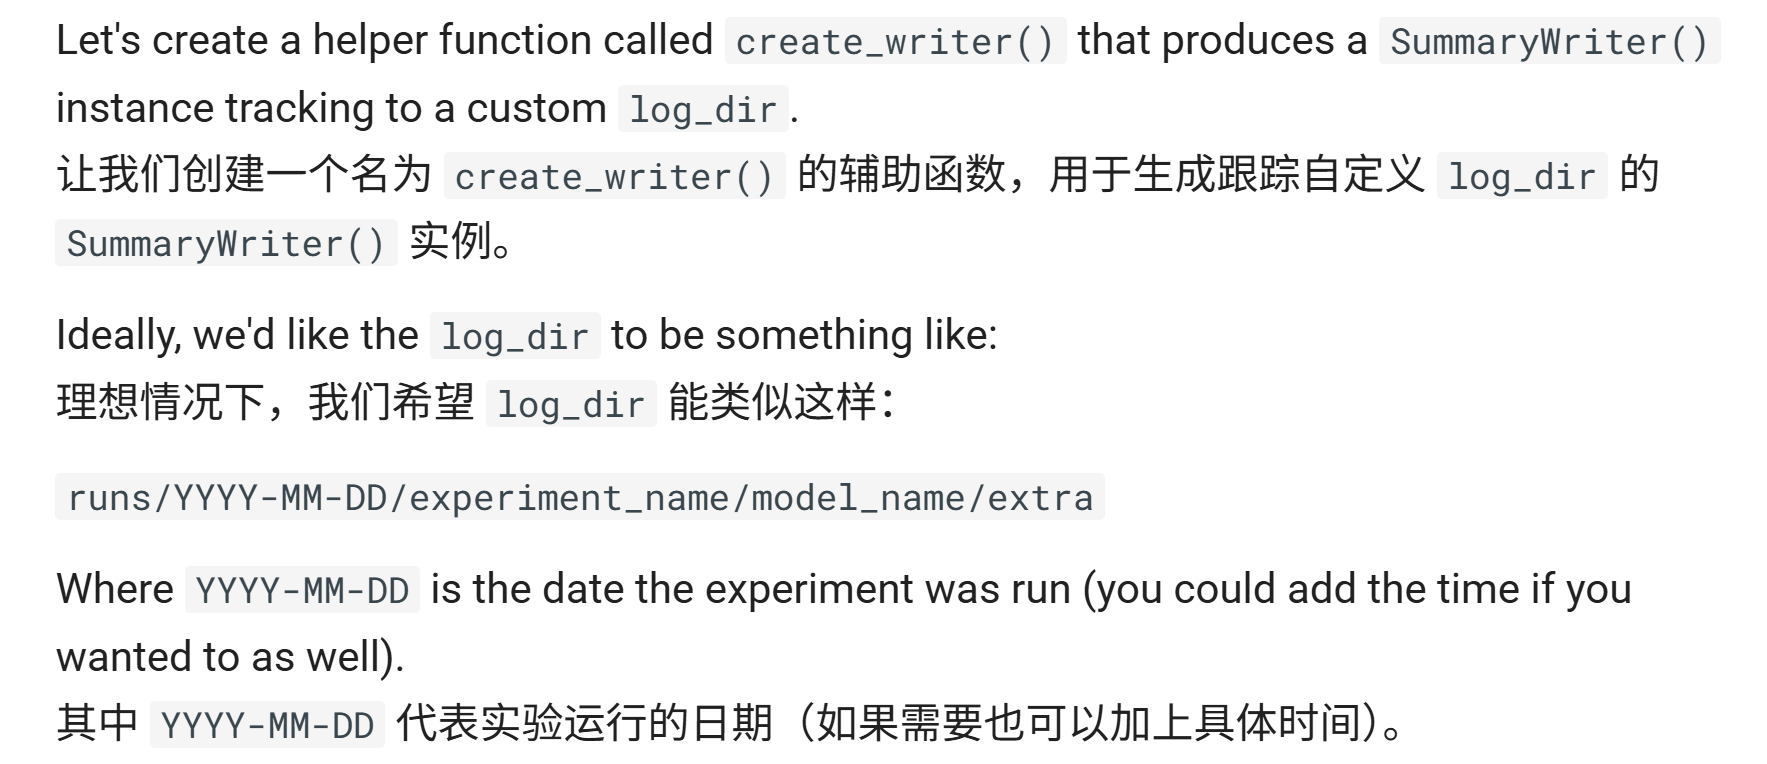

In [17]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [18]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2025-09-01/data_10_percent/effnetb0/5_epochs...
